# Neuromatch Academy: Week 3, Day 5, Tutorial 1
# Deep Learning 2: Autoencoders

__Content creators:__ Marco Brigham and the [CCNSS](https://www.ccnss.org/) team (2014-2018)

__Content reviewers:__ Itzel Olivos, Karen Schroeder, Karolina Stosio, Kshitij Dwivedi, Spiros Chavlis, Michael Waskom

---
# Tutorial Objectives

## Internal representations and autoencoders
How can simple algorithms capture relevant aspects of data and build robust models of the world?

Autoencoders are a family of artificial neural networks (ANNs) that learn internal representations through auxiliary tasks, i.e., *learning by doing*.

The primary task is to reconstruct output images based on a compressed representation of the inputs. This task teaches the network which details to throw away while still producing images that are similar to the inputs.

&nbsp; 

A fictitious *MNIST cognitive task* bundles more elaborate tasks such as removing noise from images, guessing occluded parts, and recovering original image orientation. We use the handwritten digits from the MNIST dataset since it is easier to identify similar images or issues with reconstructions than in other types of data, such as spiking data time series.

&nbsp;

![MNIST cognitive task](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/mnist_task.png)

&nbsp;

The beauty of autoencoders is the possibility to see these internal representations. The bottleneck layer enforces data compression by having fewer units than input and output layers. Further limiting this layer to two or three units enables us to see how the autoencoder is organizing the data internally in two or three-dimensional *latent space*. 

&nbsp; 

Our roadmap is the following: learn about typical elements of autoencoder architecture in Tutorial 1 (this tutorial), how to extend their performance in Tutorial 2, and use them to solve the MNIST cognitive task in Tutorial 3.

&nbsp; 

In this tutorial, you will:
- Get acquainted with latent space visualizations and apply them to *Principal Component Analysis (PCA)* and *Non-negative Matrix Factorization (NMF)*
- Build and train a single hidden layer ANN autoencoder
- Inspect the representational power of autoencoders with latent spaces of different dimensions

Video available at https://youtube.com/watch?v=FBTHsDCrXcU


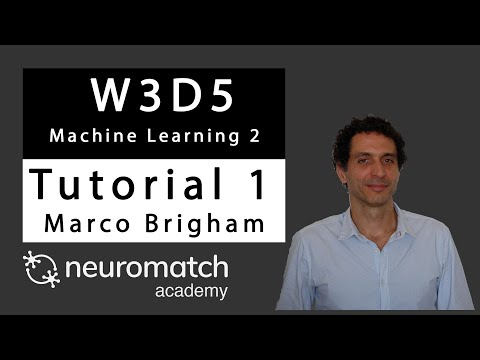

In [ ]:
#@title Video 1: Intro
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="FBTHsDCrXcU", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

# Summary of Video 1:

- starts with the mnist data set 
- take
digits and you add noise and then try to
reconstruct
the noiseless versions 
1. try to see the signal of the digits
from the noise and it requires you to
have an idea of what handwritten digits
look like 
2. second task is image
completion
where small chunks of the image are
taken out
and you are to imagine the missing part
3. third task is the digits are rotated
and you have to identify the rotation to
put them back in their original position
these are the operations of the mnist
cognitive task and as you see
they are quite challenging you need to
learn to remove noise
from images at the occluded parts
and then do a geometric transformation

auto encoders
are able to solve the unnecessary
cognitive task
in the sense that when provided we
demodified images on the output
after training they are able to recover
something that resembles the original
images

---
# Setup
Please execute the cell(s) below to initialize the notebook environment.

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim

from sklearn import decomposition
from sklearn.datasets import fetch_openml

In [ ]:
# @title Figure settings
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
fig_w, fig_h = plt.rcParams['figure.figsize']

In [ ]:
# @title Helper functions


def downloadMNIST():
  """
  Download MNIST dataset and transform it to torch.Tensor

  Args:
    None

  Returns:
    x_train : training images (torch.Tensor) (60000, 28, 28)
    x_test  : test images (torch.Tensor) (10000, 28, 28)
    y_train : training labels (torch.Tensor) (60000, )
    y_train : test labels (torch.Tensor) (10000, )
  """
  X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
  # Trunk the data
  n_train = 60000
  n_test = 10000

  train_idx = np.arange(0, n_train)
  test_idx = np.arange(n_train, n_train + n_test)

  x_train, y_train = X[train_idx], y[train_idx]
  x_test, y_test = X[test_idx], y[test_idx]

  # Transform np.ndarrays to torch.Tensor
  x_train = torch.from_numpy(np.reshape(x_train,
                                        (len(x_train),
                                         28, 28)).astype(np.float32))
  x_test = torch.from_numpy(np.reshape(x_test,
                                       (len(x_test),
                                        28, 28)).astype(np.float32))

  y_train = torch.from_numpy(y_train.astype(int))
  y_test = torch.from_numpy(y_test.astype(int))

  return (x_train, y_train, x_test, y_test)


def init_weights_kaiming_uniform(layer):
  """
  Initializes weights from linear PyTorch layer
  with kaiming uniform distribution.

  Args:
    layer (torch.Module)
        Pytorch layer

  Returns:
    Nothing.
  """
  # check for linear PyTorch layer
  if isinstance(layer, nn.Linear):
    # initialize weights with kaiming uniform distribution
    nn.init.kaiming_uniform_(layer.weight.data)


def init_weights_kaiming_normal(layer):
  """
  Initializes weights from linear PyTorch layer
  with kaiming normal distribution.

  Args:
    layer (torch.Module)
        Pytorch layer

  Returns:
    Nothing.
  """
  # check for linear PyTorch layer
  if isinstance(layer, nn.Linear):
    # initialize weights with kaiming normal distribution
    nn.init.kaiming_normal_(layer.weight.data)


def get_layer_weights(layer):
  """
  Retrieves learnable parameters from PyTorch layer.

  Args:
    layer (torch.Module)
        Pytorch layer

  Returns:
    list with learnable parameters
  """
  # initialize output list
  weights = []

  # check whether layer has learnable parameters
  if layer.parameters():
    # copy numpy array representation of each set of learnable parameters
    for item in layer.parameters():
      weights.append(item.detach().numpy().copy())

  return weights


def eval_mse(y_pred, y_true):
  """
  Evaluates Mean Square Error (MSE) between y_pred and y_true

  Args:
    y_pred (torch.Tensor)
        prediction samples

    v (numpy array of floats)
        ground truth samples

  Returns:
    MSE(y_pred, y_true)
  """

  with torch.no_grad():
      criterion = nn.MSELoss()
      loss = criterion(y_pred, y_true)

  return float(loss)


def eval_bce(y_pred, y_true):
  """
  Evaluates Binary Cross-Entropy (BCE) between y_pred and y_true

  Args:
    y_pred (torch.Tensor)
        prediction samples

    v (numpy array of floats)
        ground truth samples

  Returns:
    BCE(y_pred, y_true)
  """

  with torch.no_grad():
      criterion = nn.BCELoss()
      loss = criterion(y_pred, y_true)

  return float(loss)


def plot_weights_ab(encoder_w_a, encoder_w_b, decoder_w_a, decoder_w_b,
                    label_a='init', label_b='train',
                    bins_encoder=0.5, bins_decoder=1.5):
  """
  Plots row of histograms with encoder and decoder weights
  between two training checkpoints.

  Args:
    encoder_w_a (iterable)
        encoder weights at checkpoint a

    encoder_w_b (iterable)
        encoder weights at checkpoint b

    decoder_w_a (iterable)
        decoder weights at checkpoint a

    decoder_w_b (iterable)
        decoder weights at checkpoint b

    label_a (string)
        label for checkpoint a

    label_b (string)
        label for checkpoint b

    bins_encoder (float)
        norm of extreme values for encoder bins

    bins_decoder (float)
        norm of extreme values for decoder bins

  Returns:
    Nothing.
  """

  plt.figure(figsize=(fig_w * 1.2, fig_h * 1.2))

  # plot encoder weights
  bins = np.linspace(-bins_encoder, bins_encoder, num=32)

  plt.subplot(221)
  plt.title('Encoder weights to unit 0')
  plt.hist(encoder_w_a[0].flatten(), bins=bins, alpha=0.3, label=label_a)
  plt.hist(encoder_w_b[0].flatten(), bins=bins, alpha=0.3, label=label_b)
  plt.legend()

  plt.subplot(222)
  plt.title('Encoder weights to unit 1')
  plt.hist(encoder_w_a[1].flatten(), bins=bins, alpha=0.3, label=label_a)
  plt.hist(encoder_w_b[1].flatten(), bins=bins, alpha=0.3, label=label_b)
  plt.legend()

  # plot decoder weights
  bins = np.linspace(-bins_decoder, bins_decoder, num=32)

  plt.subplot(223)
  plt.title('Decoder weights from unit 0')
  plt.hist(decoder_w_a[:, 0].flatten(), bins=bins, alpha=0.3, label=label_a)
  plt.hist(decoder_w_b[:, 0].flatten(), bins=bins, alpha=0.3, label=label_b)
  plt.legend()

  plt.subplot(224)
  plt.title('Decoder weights from unit 1')
  plt.hist(decoder_w_a[:, 1].flatten(), bins=bins, alpha=0.3, label=label_a)
  plt.hist(decoder_w_b[:, 1].flatten(), bins=bins, alpha=0.3, label=label_b)
  plt.legend()

  plt.tight_layout()
  plt.show()


def plot_row(images, show_n=10, image_shape=None):
  """
  Plots rows of images from list of iterables (iterables: list, numpy array
  or torch.Tensor). Also accepts single iterable.
  Randomly selects images in each list element if item count > show_n.

  Args:
    images (iterable or list of iterables)
        single iterable with images, or list of iterables

    show_n (integer)
        maximum number of images per row

    image_shape (tuple or list)
        original shape of image if vectorized form

  Returns:
    Nothing.
  """

  if not isinstance(images, (list, tuple)):
    images = [images]

  for items_idx, items in enumerate(images):

    items = np.array(items)
    if items.ndim == 1:
      items = np.expand_dims(items, axis=0)

    if len(items) > show_n:
      selected = np.random.choice(len(items), show_n, replace=False)
      items = items[selected]

    if image_shape is not None:
      items = items.reshape([-1] + list(image_shape))

    plt.figure(figsize=(len(items) * 1.5, 2))
    for image_idx, image in enumerate(items):

      plt.subplot(1, len(items), image_idx + 1)
      plt.imshow(image, cmap='gray', vmin=image.min(), vmax=image.max())
      plt.axis('off')

      plt.tight_layout()


def xy_lim(x):
  """
  Return arguments for plt.xlim and plt.ylim calculated from minimum
  and maximum of x.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        data to be plotted

  Returns:
    Nothing.
  """

  x_min = np.min(x, axis=0)
  x_max = np.max(x, axis=0)

  x_min = x_min - np.abs(x_max - x_min) * 0.05 - np.finfo(float).eps
  x_max = x_max + np.abs(x_max - x_min) * 0.05 + np.finfo(float).eps

  return [x_min[0], x_max[0]], [x_min[1], x_max[1]]


def plot_generative(x, decoder_fn, image_shape, n_row=16):
  """
  Plots images reconstructed by decoder_fn from a 2D grid in
  latent space that is determined by minimum and maximum values in x.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space

    decoder_fn (integer)
        function returning vectorized images from 2D latent space coordinates

    image_shape (tuple or list)
        original shape of image

    n_row
        number of rows in grid

  Returns:
    Nothing.
  """

  xlim, ylim = xy_lim(np.array(x))

  dx = (xlim[1] - xlim[0]) / n_row
  grid = [np.linspace(ylim[0] + dx / 2, ylim[1] - dx / 2, n_row),
          np.linspace(xlim[0] + dx / 2, xlim[1] - dx / 2, n_row)]

  canvas = np.zeros((image_shape[0]*n_row, image_shape[1] * n_row))

  cmap = plt.get_cmap('gray')

  for j, latent_y in enumerate(grid[0][::-1]):
    for i, latent_x in enumerate(grid[1]):

      latent = np.array([[latent_x, latent_y]], dtype=np.float32)
      with torch.no_grad():
          x_decoded = decoder_fn(torch.from_numpy(latent))

      x_decoded = x_decoded.reshape(image_shape)

      canvas[j*image_shape[0]: (j + 1) * image_shape[0],
             i*image_shape[1]: (i + 1) * image_shape[1]] = x_decoded

  plt.imshow(canvas, cmap=cmap, vmin=canvas.min(), vmax=canvas.max())
  plt.axis('off')


def plot_latent(x, y, show_n=500, fontdict=None, xy_labels=None):
  """
  Plots digit class of each sample in 2D latent space coordinates.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space

    y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    n_row (integer)
        number of samples

    fontdict (dictionary)
        optional style option for plt.text

    xy_labels (list)
        optional list with [xlabel, ylabel]

  Returns:
    Nothing.
  """

  if fontdict is None:
    fontdict = {'weight': 'bold', 'size': 12}

  cmap = plt.get_cmap('tab10')

  if len(x) > show_n:
    selected = np.random.choice(len(x), show_n, replace=False)
    x = x[selected]
    y = y[selected]

  for my_x, my_y in zip(x, y):
    plt.text(my_x[0], my_x[1], str(int(my_y)),
             color=cmap(int(my_y) / 10.),
             fontdict=fontdict,
             horizontalalignment='center',
             verticalalignment='center',
             alpha=0.8)

  if xy_labels is None:
    xy_labels = ['$Z_1$', '$Z_2$']

  plt.xlabel(xy_labels[0])
  plt.ylabel(xy_labels[1])

  xlim, ylim = xy_lim(np.array(x))
  plt.xlim(xlim)
  plt.ylim(ylim)


def plot_latent_generative(x, y, decoder_fn, image_shape, title=None,
                           xy_labels=None):
  """
  Two horizontal subplots generated with encoder map and decoder grid.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space

    y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    decoder_fn (integer)
        function returning vectorized images from 2D latent space coordinates

    image_shape (tuple or list)
        original shape of image

    title (string)
        plot title

    xy_labels (list)
        optional lsit with [xlabel, ylabel]

  Returns:
    Nothing.
  """

  fig = plt.figure(figsize=(12, 6))

  if title is not None:
    fig.suptitle(title, y=1.05)

  ax = fig.add_subplot(121)
  ax.set_title('Encoder map', y=1.05)
  plot_latent(x, y, xy_labels=xy_labels)

  ax = fig.add_subplot(122)
  ax.set_title('Decoder grid', y=1.05)
  plot_generative(x, decoder_fn, image_shape)

  plt.tight_layout()
  plt.show()


def plot_latent_ab(x1, x2, y, selected_idx=None,
                   title_a='Before', title_b='After', show_n=500):
  """
  Two horizontal subplots with encoder maps.

  Args:
    x1 (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space (left plot)

    x2 (list, numpy array or torch.Tensor of floats)
        digit class of each sample (right plot)

    y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    selected_idx (list of integers)
        indexes of elements to be plotted

    show_n (integer)
        maximum number of samples in each plot

    s2 (boolean)
        convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)

  Returns:
    Nothing.
  """

  fontdict = {'weight': 'bold', 'size': 12}

  if len(x1) > show_n:

    if selected_idx is None:
      selected_idx = np.random.choice(len(x1), show_n, replace=False)

    x1 = x1[selected_idx]
    x2 = x2[selected_idx]
    y = y[selected_idx]

  plt.figure(figsize=(12, 6))

  ax = plt.subplot(121)
  ax.set_title(title_a, y=1.05)
  plot_latent(x1, y, fontdict=fontdict)

  ax = plt.subplot(122)
  ax.set_title(title_b, y=1.05)
  plot_latent(x2, y, fontdict=fontdict)

  plt.tight_layout()


def runSGD(net, input_train, input_test, criterion='bce',
           n_epochs=10, batch_size=32, verbose=False):
  """
  Trains autoencoder network with stochastic gradient descent with Adam
  optimizer and loss criterion. Train samples are shuffled, and loss is
  displayed at the end of each epoch for both MSE and BCE. Plots training loss
  at each minibatch (maximum of 500 randomly selected values).

  Args:
    net (torch network)
        ANN object (nn.Module)

    input_train (torch.Tensor)
        vectorized input images from train set

    input_test (torch.Tensor)
        vectorized input images from test set

    criterion (string)
        train loss: 'bce' or 'mse'

    n_epochs (boolean)
        number of full iterations of training data

    batch_size (integer)
        number of element in mini-batches

    verbose (boolean)
        whether to print final loss

  Returns:
    Nothing.
  """

  # Initialize loss function
  if criterion == 'mse':
    loss_fn = nn.MSELoss()
  elif criterion == 'bce':
    loss_fn = nn.BCELoss()
  else:
    print('Please specify either "mse" or "bce" for loss criterion')

  # Initialize SGD optimizer
  optimizer = optim.Adam(net.parameters())

  # Placeholder for loss
  track_loss = []

  print('Epoch', '\t', 'Loss train', '\t', 'Loss test')
  for i in range(n_epochs):

    shuffle_idx = np.random.permutation(len(input_train))
    batches = torch.split(input_train[shuffle_idx], batch_size)

    for batch in batches:

      output_train = net(batch)
      loss = loss_fn(output_train, batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Keep track of loss at each epoch
      track_loss += [float(loss)]

    loss_epoch = f'{i + 1} / {n_epochs}'
    with torch.no_grad():
      output_train = net(input_train)
      loss_train = loss_fn(output_train, input_train)
      loss_epoch += f'\t {loss_train:.4f}'

      output_test = net(input_test)
      loss_test = loss_fn(output_test, input_test)
      loss_epoch += f'\t\t {loss_test:.4f}'

    print(loss_epoch)

  if verbose:
    # Print final loss
    loss_mse = f'\nMSE\t {eval_mse(output_train, input_train):0.4f}'
    loss_mse += f'\t\t {eval_mse(output_test, input_test):0.4f}'
    print(loss_mse)

    loss_bce = f'BCE\t {eval_bce(output_train, input_train):0.4f}'
    loss_bce += f'\t\t {eval_bce(output_test, input_test):0.4f}'
    print(loss_bce)

  # Plot loss
  step = int(np.ceil(len(track_loss) / 500))
  x_range = np.arange(0, len(track_loss), step)
  plt.figure()
  plt.plot(x_range, track_loss[::step], 'C0')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.xlim([0, None])
  plt.ylim([0, None])
  plt.show()

# Summary of Helper functions:

*downloadMNIST()*: Download MNIST dataset, trunk the data into train and test and transform numpy ndarrays to torch.Tensor

*init_weights_kaiming_uniform(layer)*: Initializes weights from linear PyTorch layer with kaiming uniform distribution.

*get_layer_weights(layer)*: Retrieves learnable parameters from PyTorch layer
by copying numpy array representation of each set of learnable parameters

*eval_mse(y_pred, y_true)*: Evaluates Mean Square Error (MSE) between y_pred and y_true

*eval_bce(y_pred, y_true)*: Evaluates Binary Cross-Entropy (BCE) between y_pred and y_true

*plot_weights_ab(encoder_w_a, encoder_w_b, decoder_w_a, decoder_w_b,
                    label_a='init', label_b='train',
                    bins_encoder=0.5, bins_decoder=1.5)*: Plots row of histograms with encoder and decoder weights between two training checkpoints.

*plot_row(images, show_n=10, image_shape=None)*:
Plots rows of images from list of iterables (iterables: list, numpy array or torch.Tensor). Also accepts single iterable. Randomly selects images in each list element if item count > show_n.

*xy_lim(x)*: Return arguments for plt.xlim and plt.ylim calculated from minimum and maximum values in x.

*plot_generative(x, decoder_fn, image_shape, n_row=16)*: Plots images reconstructed by decoder_fn from a 2D grid in latent space that is determined by minimum and maximum values in x.

*plot_latent(x, y, show_n=500, fontdict=None, xy_labels=None)*: Plots digit class of each sample in 2D latent space coordinates.

*plot_latent_generative(x, y, decoder_fn, image_shape, title=None, xy_labels=None)*: Two horizontal subplots generated with encoder map and decoder grid.

*plot_latent_ab(x1, x2, y, selected_idx=None,
                   title_a='Before', title_b='After', show_n=500)*: Two horizontal subplots with encoder maps.

*runSGD(net, input_train, input_test, criterion='bce',
           n_epochs=10, batch_size=32, verbose=False)*:

  Trains autoencoder network with stochastic gradient descent with Adam
  optimizer and loss criterion. Train samples are shuffled, and loss is
  displayed at the end of each opoch for both MSE and BCE. Plots training loss
  at each minibatch (maximum of 500 randomly selected values) - iterations (xaxis) vs loss (yaxis).

---
# Section 1: Introduction to autoencoders

Video available at https://youtube.com/watch?v=hefek_yhEKs


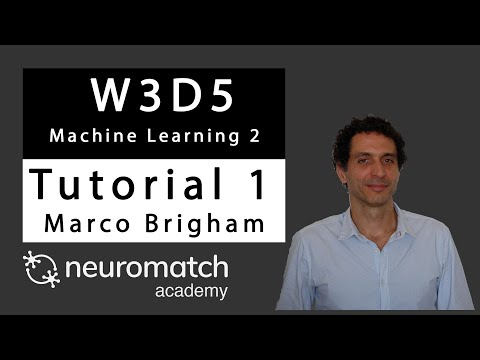

In [ ]:
#@title Video 2: Autoencoders
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="hefek_yhEKs", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

# Summary of Video 2:

- autoencoders that are artificial neural networks that learn
representations of data
by compressing data into
a lower dimensionality representation in the bottleneck layer,
and reconstruct it back into the original dimensionality.

- So let's call x our inputs and let's say x is an image;
Let's call z the representation of the input in the bottleneck layer, which we also call latent space, and let's call x tilde
the reconstructed
output.
And we want that the output resembles as closely as possible the input.

- autoencoder
that has one hidden layer also called a shallow autoencoder.
Now the autoencoder can still be divided into components: the encoder component, that goes from the input into the bottleneck
layer, and the decoder component that goes from bottleneck layer into the output.
and actually the
autoencoder
is a sequence of encoding of inputs into bottleneck layer and then decoding
of bottleneck layer into the outputs.

- Our autoencoder tries to recover the inputs x on the output
and is constrained by representing the inputs into the bottleneck layer
that has less
units than our inputs and outputs.

- The encoder map represents each sample by its
class
digit
in the
latent space the bottleneck layer.
Here is the y coordinates and here is the x coordinates.

So each one of these samples is an image, here x, and the location on
the bottleneck layer z
is given by a coordinate in the encoder map and the digits that are represented is the digit class.
The decoder grid
is
an equally spaced
grid on bottleneck layer
that then is reconstructed
back. So we go to bottleneck layer and we take equally spaced intervals in
x and y, and then each one of these points we reconstruct it by feeding it to the decoder.

- both PCA - principal component analysis and NMF - non-negative matrix factorisation
and can be used as a linear dimensionality reduction
tools.

- Now we'll compare
PCA with our shallow auto encoder,
these are two very different
techniques and 
the autoencoder is a purely non-linear dimensionality reduction technique

- But after comparison we see that results are very similar,
the autoencoder and PCA,
the shallow autoencoder they mostly separate digits ones from zero, but it's not very
separable for the other digit classes.


This tutorial introduces typical elements of autoencoders, that learn low dimensional representations of data through an auxiliary task of compression and decompression. In general, these networks are characterized by an equal number of input and output units and a *bottleneck layer* with fewer units.

![Single hidden layer ANN autoencoder](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/ae-ann-1h.png)

Autoencoder architectures have *encoder* and *decoder* components:
* The encoder network compresses high dimensional inputs into lower-dimensional coordinates of the *bottleneck layer* 
* The *decoder* expands *bottleneck layer* coordinates back to the original dimensionality

Each input presented to the autoencoder maps to a coordinate in the bottleneck layer that spans the lower-dimensional *latent space*.

&nbsp; 

Differences between inputs and outputs trigger the backpropagation of loss to adjust weights and better compress/decompress data.  Autoencoders are examples of models that automatically build internal representations of the world and use them to predict unseen data.

We'll use fully-connected AAN architectures due to their lower computational requirements. The inputs to ANNs are *vectorized* versions of the images (i.e., stretched as a line).

---
# Section 2: The MNIST dataset
The [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) contains handwritten digits in square images of 28x28 pixels of grayscale levels. There are 60,000 training images and 10,000 testing images from different writers.

Get acquainted with the data by inspecting data type, shape, and visualizing samples with the function `plot_row`.

**Helper function:** `plot_row`

Please uncomment the line below to inspect this function.

In [ ]:
# help(plot_row)

## Section 2.1: Download  and prepare MNIST dataset
We use the helper function `downloadMNIST` to download the dataset, transform it into `torch.Tensor` and assign train and test datasets to (`x_train`, `y_train`) and (`x_test`, `y_test`), respectively.

(`x_train`, `x_test`) contain images and (`y_train`, `y_test`) contain labels from `0` to `9`.

The original pixel values are integers between `0` and `255`. We rescale them between `0` and `1`, a more favorable range for training the autoencoders in this tutorial.

The images are *vectorized*, i.e., stretched as a line. We reshape training and testing images to *vectorized* versions with the method `.reshape` and store them in variable `input_train` and `input_test`, respectively. The variable `image_shape` stores the shape of the images, and `input_size` stores the size of the *vectorized* versions.

**Instructions:**
* Please execute the cell below

**Questions:**
* What are the shape and numeric representations of `x_train` and `input_train`?
* What is the image shape?

In [ ]:
# Download MNIST
x_train, y_train, x_test, y_test = downloadMNIST()

x_train = x_train / 255
x_test = x_test / 255

image_shape = x_train.shape[1:]

input_size = np.prod(image_shape)

input_train = x_train.reshape([-1, input_size])
input_test = x_test.reshape([-1, input_size])

test_selected_idx = np.random.choice(len(x_test), 10, replace=False)
train_selected_idx = np.random.choice(len(x_train), 10, replace=False)

print(f'shape x_train \t\t {x_train.shape}')
print(f'shape x_test \t\t {x_test.shape}')
print(f'shape image \t\t {image_shape}')
print(f'shape input_train \t {input_train.shape}')
print(f'shape input_test \t {input_test.shape}')

## Visualize samples
The variables `train_selected_idx` and `test_selected_idx` store 10 random indexes from the train and test data.

We use the function `np.random.choice` to select 10 indexes from `x_train` and `y_train` without replacement (`replacement=False`).

**Instructions:**
* Please execute the cells below
* The first cell display different samples each time, the second cell always displays the same samples

In [ ]:
# top row: random images from test set
# bottom row: images selected with test_selected_idx

plot_row([x_test, x_test[test_selected_idx]])

---
# Section 3: Latent space visualization
This section introduces tools for visualization of latent space and applies them to *Principal Component Analysis (PCA)*, already introduced in tutorial *W1D5 Dimensionality reduction*. Please see the exercise in the *Bonus* section for *Non-negative Matrix Factorization (NMF)*.

&nbsp;

The plotting function `plot_latent_generative` helps visualize the encoding of inputs from high dimension into 2D latent space, and decoding back to the original dimension. This function produces two plots:

* **Encoder map** shows the mapping from input images to coordinates $(z_1, z_2)$ in latent space, with overlaid digit labels
* **Decoder grid** shows reconstructions from a grid of latent space coordinates $(z_1, z_2)$

&nbsp;

![Latent space visualization](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/latent_space_plots_noaxis.png)

The latent space representation is a new coordinate system $(z_1, z_2)$ that hopefully captures relevant structure from high-dimensional data. The coordinates of each input only matter relative to those of other inputs, i.e., we often care about separability between different classes of digits rather than their location.

&nbsp;

The encoder map provides direct insight into the organization of latent space. Keep in mind that latent space only contains coordinates $(z_1, z_2)$. We overlay additional information such as digit labels for insight into the latent space structure. 

The plot on the left is the raw latent space representation corresponding to the plot on the right with digit labels overlaid.

![Raw latent space visualization](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/latent_space_plots_nolabel.png)

## Section 3.1: MNIST with PCA

## Exercise 1: Visualize PCA latent space (2D)
The tutorial *W1D5 Dimensionality reduction* introduced PCA decomposition. The case of two principal components (PCA1 and PCA2) generates a latent space in 2D.

![Latent space visualization PCA](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/latent_space_plots_pca.png)

In tutorial W1D5, PCA decomposition was implemented directly and also by using module [sklearn.decomposition](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) from the package [scikit-learn](https://scikit-learn.org). This module includes several matrix decomposition algorithms that are useful as dimensionality reduction techniques.

Their usage is very straightforward, as shown by this example for truncated SVD:
```
svd = decomposition.TruncatedSVD(n_components=2)

svd.fit(input_train)

svd_latent_train = svd.transform(input_train)
svd_latent_test = svd.transform(input_test)

svd_reconstruction_train = svd.inverse_transform(svd_latent_train)
svd_reconstruction_test = svd.inverse_transform(svd_latent_test)
```

in this exercise, we'll use `decomposition.PCA` (docs [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)) for PCA decomposition.

**Instructions:**
* Initialize `decomposition.PCA` in 2 dimensions
* Fit `input_train` with `.fit` method of `decomposition.PCA`
* Obtain latent space representation of `input_test`
* Visualize latent space with `plot_latent_generative`

**Helper function:** `plot_latent_generative`

Please uncomment the line below to inspect this function.

In [ ]:
# @title

# @markdown Execute this cell to inspect `plot_latent_generative`!
help(plot_latent_generative)

In [ ]:
####################################################
## TODO for students: perform PCA and visualize latent space and reconstruction
####################################################
# create the model
# pca = decomposition.PCA(...)
# fit the model on training data
# pca.fit(...)
# transformation on 2D space
# pca_latent_test = pca.transform(...)

# Uncomment to test your code!
# plot_latent_generative(pca_latent_test, y_test, pca.inverse_transform,
#                        image_shape=image_shape)

In [ ]:
# to_remove solution
# create the model
pca = decomposition.PCA(n_components=2)
# fit the model on training data
pca.fit(input_train)
# transformation on 2D space
pca_latent_test = pca.transform(input_test)

# Uncomment to test your code!
with plt.xkcd():
  plot_latent_generative(pca_latent_test, y_test, pca.inverse_transform,
                         image_shape=image_shape)

## Section 3.2: Qualitative analysis PCA
The encoder map shows how well the encoder is distinguishing between digit classes. We see that digits `1` and `0` are in opposite regions of the first principal component axis, and similarly for digits `9` and `3` for the second principal component.

The decoder grid indicates how well the decoder is recovering images from latent space coordinates. Overall, digits `1`, `0`, and `9` are the most recognizable.

Let's inspect the principal components to understand these observations better. The principal components are available as `pca.components_` and shown below.

![principal components](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/pca-components.png)

Notice that the first principal component encodes digit `0` with positive values (in white) and digit `1` in negative values (in black). The colormap encodes the minimum values in black and maximum values in white, and we know their signs by looking at coordinates in the first principal component axis for digits `0` and `1`.

&nbsp; 

The first principal component axis encodes the "thickness" of the digits: thin digits on the left and tick digits on the right.

Similarly, the second principal component encodes digit `9` with positive values (in white) and digit `3` with negative values (in black).

The second principal component axis is encoding, well, another aspect besides "thickness" of digits (why?).

The reconstruction grid also shows that digits `4` and `7` are indistinguishable from digit `9` and similarly for digits `2` and `3`.


**Instructions:**
* Please execute the cell(s) below
* Plot reconstruction samples a few times to get a visual feel of the digit confusions (use keyword `image_shape` to visualize the vectorized images).

In [ ]:
pca_components = pca.components_

plot_row(pca_components, image_shape=image_shape)

In [ ]:
pca_output_test = pca.inverse_transform(pca_latent_test)

plot_row([input_test, pca_output_test], image_shape=image_shape)

---
# Section 4: ANN autoencoder
Let's implement a *shallow* ANN autoencoder with a single hidden layer.

![Single hidden layer ANN autoencoder](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/ae-ann-1h.png)

## Design ANN autoencoder (32D)
Here we introduce a technique for quickly building Pytorch models best suited for the initial exploration phase of your research project. 

The object-oriented programming (OOP) presented in tutorial W3D4 is your top choice after better understanding the model's architecture and components.

Using this concise technique, a network equivalent to `DeepNetReLU` from W3D4 tutorial 1 is defined as:
```
model = nn.Sequential(nn.Linear(n_input, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_output))
```
Designing and training efficient neural networks currently requires some thought, experience, and testing for choosing between available options, such as the number of hidden layers, loss function, optimizer function, mini-batch size, etc. Choosing these hyper-parameters may soon become more of an engineering process with our increasing analytical understanding of these systems and their learning dynamics.

The references below are great to learn more about neural network design and best practices:
*  [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com) by Michael Nielsen is an excellent reference for beginners
* [Deep Learning](http://www.deeplearningbook.org) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville provides in-depth and extensive coverage
* [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, momentum, and weight decay](https://arxiv.org/abs/1803.09820) by L. Smith covers efficient ways to set hyper-parameters

### Exercise 2: Design ANN autoencoder
We will use a rectifier [ReLU](https://icml.cc/Conferences/2010/papers/432.pdf) units in the bottleneck layer with `encoding_dim=32` units, and sigmoid units in the output layer. You can read more about activation functions [here](https://en.wikipedia.org/wiki/Activation_function) and rectifiers [here](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)).

![ReLU unit](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/relu.png)

![Single hidden layer ANN autoencoder](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/sigmoid.png)

We rescaled images to values between `0` and `1` for compatibility with sigmoid units in the output (why?). Such mapping is without loss of generality since any (finite) range can map a one-to-one correspondence to values between `0` and `1`.

Both ReLU and sigmoid units provide non-linear computation to the encoder and decoder components. The sigmoid units, additionally, ensure output values to be in the same range as the inputs. These units could be swapped by ReLU, in which case output values would sometimes be negative or greater than 1. The sigmoid units of the decoder enforce a numerical constraint that expresses our *domain knowledge* of the data.

**Instructions**
* `nn.Sequential` defines and initializes an ANN with layer sizes (`input_shape, encoding_dim, input_shape`)
* `nn.Linear` defines a linear layer with the size of the inputs and outputs as arguments
* `nn.ReLU` and `nn.Sigmoid` encode ReLU and sigmoid units
* Visualize the initial output using `plot_row` with input and output images

In [ ]:
encoding_size = 32

model = nn.Sequential(
    nn.Linear(input_size, encoding_size),
    nn.ReLU(),
    ######################################################################
    ## TODO for students: add linear and sigmoid layers
    ######################################################################
    # insert your code here to add the layer
    # nn.Linear(...),
    # insert the activation function
    # ....
    )

print(f'Model structure \n\n {model}')

In [ ]:
# to_remove solution
encoding_size = 32

model = nn.Sequential(
    nn.Linear(input_size, encoding_size),
    nn.ReLU(),
    # insert your code here to add the layer
    nn.Linear(encoding_size, input_size),
    # insert the activation function
    nn.Sigmoid()
    )

print(f'Model structure \n\n {model}')

**SAMPLE OUTPUT**

```
Sequential(
  (0): Linear(in_features=784, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=784, bias=True)
  (3): Sigmoid()
)
```

In [ ]:
with torch.no_grad():
  output_test = model(input_test)

plot_row([input_test.float(), output_test], image_shape=image_shape)

## Train autoencoder (32D)
The function `runSGD` trains the autoencoder with stochastic gradient descent using Adam optimizer (`optim.Adam`) and provides a choice between Mean Square Errors (MSE  with `nn.MSELoss`) and Binary Cross-entropy (BCE with `nn.BCELoss`).

The figures below illustrate these losses, where $\hat{Y}$ is the output value, and $Y$ is the target value.

![MSE loss](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/mse.png)

![BCE loss](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/bce.png)

Train the network for `n_epochs=10` epochs and `batch_size=64` with `runSGD` and MSE loss, and visualize a few reconstructed samples.

Please execute the cells below to construct and train the model!

In [ ]:
encoding_size = 32

model = nn.Sequential(
    nn.Linear(input_size, encoding_size),
    nn.ReLU(),
    nn.Linear(encoding_size, input_size),
    nn.Sigmoid()
    )

n_epochs = 10
batch_size = 64

runSGD(model, input_train, input_test, criterion='mse',
       n_epochs=n_epochs, batch_size=batch_size)

In [ ]:
with torch.no_grad():
  output_test = model(input_test)

plot_row([input_test[test_selected_idx], output_test[test_selected_idx]],
         image_shape=image_shape)

## Choose the loss function
The loss function determines what the network is optimizing during training, and this translates to the visual aspect of reconstructed images. 

For example, isolated black pixels in the middle of white regions are very unlikely and look noisy. The network can prioritize avoiding such scenarios by maximally penalizing white pixels that turn out black and vice-versa.

The figure below compares MSE with BCE with a target pixel value $Y=1$, and the output ranging from $\hat{Y}\in [0, 1]$. The MSE loss has a gentle quadratic rise in this range. Notice how BCE loss dramatically increases for dark pixels $\hat{Y}$ lower than 0.4.

![bce vs. MSE loss](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/bce-mse.png)

Let's look at their derivatives $d\,\text{Loss}/d\,\hat{Y}$ to make this comparison more objective. The derivative of MSE loss is linear with slope $-2$, whereas BCE takes off as $1/\hat{Y}$ for dark pixel values (why?). 

![bce vs. MSE loss](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/bce-mse-dloss.png)

We reduced the plotting range to $[0.05, 1]$ to share the same y-axis scale for both loss functions (why?).

Let's switch to BCE loss and verify the effects of maximally penalizing white pixels that turn out black and vice-versa. The visual differences between losses will be subtle since the network is converging well in both cases.

**Look for isolated white/black pixel areas in MSE loss reconstructions.**

We will first retrain under MSE loss for `2` epochs to accentuate differences, and similarly under BCE loss.

Please execute the cells below to train with MSE and BCE, respectively.

In [ ]:
encoding_size = 32
n_epochs = 2
batch_size = 64

model = nn.Sequential(
    nn.Linear(input_size, encoding_size),
    nn.ReLU(),
    nn.Linear(encoding_size, input_size),
    nn.Sigmoid()
    )

runSGD(model, input_train, input_test, criterion='mse',
       n_epochs=n_epochs, batch_size=batch_size, verbose=True)

In [ ]:
with torch.no_grad():
  output_test = model(input_test)

plot_row([input_test[test_selected_idx], output_test[test_selected_idx]],
         image_shape=image_shape)

In [ ]:
encoding_size = 32
n_epochs = 2
batch_size = 64

model = nn.Sequential(
    nn.Linear(input_size, encoding_size),
    nn.ReLU(),
    nn.Linear(encoding_size, input_size),
    nn.Sigmoid()
    )

runSGD(model, input_train, input_test, criterion='bce',
       n_epochs=n_epochs, batch_size=batch_size, verbose=True)

In [ ]:
with torch.no_grad():
  output_test = model(input_test)

plot_row([input_test[test_selected_idx], output_test[test_selected_idx]],
         image_shape=image_shape)

## Design ANN autoencoder (2D)
Reducing the number of bottleneck units to `encoding_size=2` generates a 2D latent space as for PCA before. The coordinates $(z_1, z_2)$  of the encoder map represent unit activations in the bottleneck layer.

&nbsp;

![encoder map for autoencoder](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/latent_space_plots_ae.png)

&nbsp;

The `encoder` component provides ($z_1, z_2$) coordinates in latent space, and the `decoder` component generates image reconstructions from ($z_1, z_2$). Specifying a sequence of layers from the autoencoder network defines these sub-networks.

```
model = nn.Sequential(...)
encoder = model[:n]
decoder = model[n:]
```

This architecture works well with a bottleneck layer with 32 units but fails to converge with two units.  Check the exercises in *Bonus* section to understand this failure more and two options to address it: better weight initialization and changing the activation function.

Here we opt for [PReLU units](https://arxiv.org/abs/1502.01852) in the bottleneck layer to add negative activations with a learnable parameter. This change affords additional wiggle room for the autoencoder to model data with only two units in the bottleneck layer.

![PreLU unit](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/prelu.png)

**Instructions**
* Please execute the cells below:

In [ ]:
encoding_size = 2

model = nn.Sequential(
    nn.Linear(input_size, encoding_size),
    nn.PReLU(),
    nn.Linear(encoding_size, input_size),
    nn.Sigmoid()
    )

encoder = model[:2]
decoder = model[2:]

print(f'Autoencoder \n\n {model}')

In [ ]:
print(f'Encoder \n\n {encoder}')

In [ ]:
print(f'Decoder \n\n {decoder}')

## Train the autoencoder (2D)
Train the network for `n_epochs=10` epochs and `batch_size=64` with `runSGD` and BCE loss, and visualize latent space.

Please execute the cells below to train the autoencoder!

In [ ]:
n_epochs = 10
batch_size = 64

# train the autoencoder
runSGD(model, input_train, input_test, criterion='bce',
       n_epochs=n_epochs, batch_size=batch_size)

In [ ]:
with torch.no_grad():
  latent_test = encoder(input_test)

plot_latent_generative(latent_test, y_test, decoder,
                       image_shape=image_shape)

## Expressive power in 2D
The latent space representation of shallow autoencoder with a 2D bottleneck is similar to that of PCA. How can this linear dimensionality reduction technique be comparable to our non-linear autoencoder?

Training an autoencoder with linear activation functions under MSE loss is [very similar to performing PCA](https://arxiv.org/abs/1804.10253). Using piece-wise linear units, sigmoidal output unit, and BCE loss doesn't seem to change this behavior qualitatively. The network lacks capacity in terms of learnable parameters to make good use of its non-linear operations and capture non-linear aspects of the data.

The similarity between representations is apparent when plotting decoder maps side-by-side. Look for classes of digits that cluster successfully, and those still mixing with others. 

Execute the cell below for a PCA vs. Autoencoder (2D) comparison!

In [ ]:
plot_latent_ab(pca_latent_test, latent_test, y_test,
               title_a='PCA', title_b='Autoencoder (2D)')

---
# Summary
In this tutorial, we got comfortable with the basic techniques to create and visualize low-dimensional representations and build shallow autoencoders. 

**We saw that PCA and shallow autoencoder have similar expressive power in 2D latent space, despite the autoencoder's non-linear character.**

The shallow autoencoder lacks learnable parameters to take advantage of non-linear operations in encoding/decoding and capture non-linear patterns in data.

The next tutorial extends the autoencoder architecture to learn richer internal representations of data required for tackling the MNIST cognitive task.

Video available at https://youtube.com/watch?v=V0gVrkyFd0Y


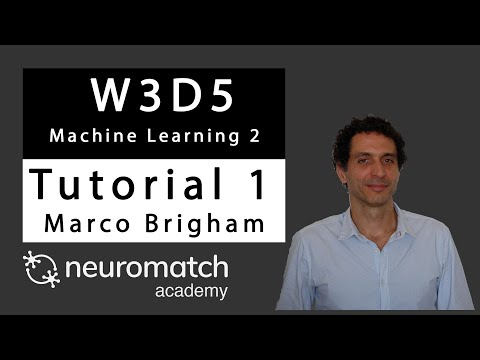

In [ ]:
#@title Video 3: Wrap-up
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="V0gVrkyFd0Y", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

# Summary of Video 3:

- learned about autoencoders and its basic components and representation
- learned about
the encoder map and the decoder grid that help us visualize the organization and structure of latent space.
We've applied it to PCA
and to help us visualize how the principle components organize latent space in the principal component directions,
and we've compared
PCA
with a shallow autoencoder and saw
that
the autoencoder with one single hidden layer is not much better than PCA in terms of clustering
digits.


---
# Bonus

## Failure mode with ReLU units in 2D
An architecture with two units in the bottleneck layer, ReLU units, and default weight initialization may fail to converge, depending on the minibatch sequence, choice of the optimizer, etc. To illustrate this failure mode, we first set the random number generators (RNGs) to reproduce an example of failed convergence:
```
torch.manual_seed(0)
np.random.seed(0)
```
Afterward, we set the RNGs to reproduce an example of successful convergence:

```
torch.manual_seed(1)
```

&nbsp;

Train the network for `n_epochs=10` epochs and `batch_size=64` and check the encoder map and reconstruction grid in each case.

We then activate our x-ray vision and check the distribution of weights in encoder and decoder components. Recall that encoder maps input pixels to bottleneck units (encoder weights `shape=(2, 784)`), and decoder maps bottleneck units to output pixels (decoder weights `shape=(784, 2)`).

Network models often initialize with random weights close to 0. The default weight initialization for linear layers in Pytorch is sampled from a uniform distribution `[-limit, limit]` with `limit=1/sqrt(fan_in)`, where `fan_in` is the number of input units in the weight tensor.

We compare the distribution of weights on network initialization to that after training. Weights that fail to learn during training keep to their initial distribution. On the other hand, weights that are adjusted by SGD during training are likely to have a change in distribution.

Encoder weights may even acquire a bell-shaped form. This effect may be related to the following: SGD adds a sequence of positive and negative increments to each initial weight. The Central Limit Theorem (CLT) would predict a gaussian histogram if increments were independent in sequences and between sequences. The deviation from gaussianity is a measure of the inter-dependency of SGD increments.

**Instructions:**
* Please execute the cells below
* Start with `torch.manual_seed = 0` for an example of failed convergence
* Check encoder mapping collapsed into a single axis
* Verify collapsed dimension corresponds to unchanged weights
* Change `torch.manual_seed = 1` for an example of successful convergence
* Run `help(get_layer_weights)` for additional details on retrieving learnable parameters (weights and biases)

In [ ]:
encoding_size = 2
n_epochs = 10
batch_size = 64

# set PyTorch RNG seed
torch_seed = 0

# reset RNG for weight initialization
torch.manual_seed(torch_seed)
np.random.seed(0)

model = nn.Sequential(
    nn.Linear(input_size, encoding_size),
    nn.ReLU(),
    nn.Linear(encoding_size, input_size),
    nn.Sigmoid()
    )

encoder = model[:2]
decoder = model[2:]

# retrieve weights and biases from the encoder before training
encoder_w_init, encoder_b_init = get_layer_weights(encoder[0])
decoder_w_init, decoder_b_init = get_layer_weights(decoder[0])

# reset RNG for minibatch sequence
torch.manual_seed(torch_seed)
np.random.seed(0)

# train the autoencoder
runSGD(model, input_train, input_test, criterion='bce',
       n_epochs=n_epochs, batch_size=batch_size)

# retrieve weights and biases from the encoder after training
encoder_w_train, encoder_b_train = get_layer_weights(encoder[0])
decoder_w_train, decoder_b_train = get_layer_weights(decoder[0])

In [ ]:
with torch.no_grad():
  latent_test = encoder(input_test)
  output_test = model(input_test)

plot_latent_generative(latent_test, y_test, decoder, image_shape=image_shape)

plot_row([input_test[test_selected_idx], output_test[test_selected_idx]],
         image_shape=image_shape)

In [ ]:
plot_weights_ab(encoder_w_init, encoder_w_train, decoder_w_init,
                decoder_w_train)

### Exercise 3: Choosing weight initialization
An improved weight initialization for ReLU units avoids the failure mode from the previous exercise. A popular choice for rectifier units is *Kaiming uniform*: sampling from uniform distribution $\mathcal{U}(-limit, limit)$ with $limit=\sqrt{6/fan\_in}$, where $fan\_in$ is the number of input units in the weight tensor (see the relevant [article](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf) for details). Example of resetting all autoencoder weights to Kaiming uniform:
```
model.apply(init_weights_kaiming_uniform)
```
An alternative is to sample from a gaussian distribution $\mathcal{N}(\mu, \sigma^2)$ with $\mu=0$ and $\sigma=1/\sqrt{fan\_in}$. Example for resetting all but the two last autoencoder layers to Kaiming normal:
```
model[:-2].apply(init_weights_kaiming_normal)
```

For more information on weight initialization, the references below are a good starting point:
* [Efficient Backprop](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf)
* [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)
* [Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf)

**Instructions:**
* Reset encoder weights with `init_weights_kaiming_uniform`
* Compare with resetting with `init_weights_kaiming_normal`
* See `help(init_weights_kaiming_uniform)` and `help(init_weights_kaiming_normal)` for additional details

In [ ]:
encoding_size = 2
n_epochs = 10
batch_size = 64

# set PyTorch RNG seed
torch_seed = 0

model = nn.Sequential(
    nn.Linear(input_size, encoding_size),
    nn.ReLU(),
    nn.Linear(encoding_size, input_size),
    nn.Sigmoid()
    )

encoder = model[:2]
decoder = model[2:]

# reset RNGs for weight initialization
torch.manual_seed(torch_seed)
np.random.seed(0)

######################################################################
## TODO for students: reset encoder weights and biases
######################################################################
# reset encoder weights and biases
# encoder.apply(...)

# retrieve weights and biases from the encoder before training
encoder_w_init, encoder_b_init = get_layer_weights(encoder[0])
decoder_w_init, decoder_b_init = get_layer_weights(decoder[0])

# reset RNGs for minibatch sequence
torch.manual_seed(torch_seed)
np.random.seed(0)

# train the autoencoder
runSGD(model, input_train, input_test, criterion='bce',
       n_epochs=n_epochs, batch_size=batch_size)

# retrieve weights and biases from the encoder after training
encoder_w_train, encoder_b_train = get_layer_weights(encoder[0])
decoder_w_train, decoder_b_train = get_layer_weights(decoder[0])

In [ ]:
# to_remove solution
encoding_size = 2
n_epochs = 10
batch_size = 64

# set PyTorch RNG seed
torch_seed = 0

model = nn.Sequential(
    nn.Linear(input_size, encoding_size),
    nn.ReLU(),
    nn.Linear(encoding_size, input_size),
    nn.Sigmoid()
    )

encoder = model[:2]
decoder = model[2:]

# reset RNGs for weight initialization
torch.manual_seed(torch_seed)
np.random.seed(0)

# reset encoder weights and biases
encoder.apply(init_weights_kaiming_uniform)

# retrieve weights and biases from the encoder before training
encoder_w_init, encoder_b_init = get_layer_weights(encoder[0])
decoder_w_init, decoder_b_init = get_layer_weights(decoder[0])

# reset RNGs for minibatch sequence
torch.manual_seed(torch_seed)
np.random.seed(0)

# train the autoencoder
runSGD(model, input_train, input_test, criterion='bce',
       n_epochs=n_epochs, batch_size=batch_size)

# retrieve weights and biases from the encoder after training
encoder_w_train, encoder_b_train = get_layer_weights(encoder[0])
decoder_w_train, decoder_b_train = get_layer_weights(decoder[0])

In [ ]:
with torch.no_grad():
  latent_test = encoder(input_test)
  output_test = model(input_test)

plot_latent_generative(latent_test, y_test, decoder,
                       image_shape=image_shape)

plot_row([input_test[test_selected_idx], output_test[test_selected_idx]],
         image_shape=image_shape)

In [ ]:
plot_weights_ab(encoder_w_init, encoder_w_train, decoder_w_init,
                decoder_w_train)

## Choose the activation function
An alternative to specific weight initialization is to choose an activation unit that performs better in this context. We will use [PReLU](https://arxiv.org/abs/1502.01852) units in the bottleneck layer, which adds a learnable parameter for negative activations. 

This change affords a little bit more of wiggle room for the autoencoder to model data compared to ReLU units.

![PreLU unit](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/prelu.png)


**Instructions:**
* Please execute the cells below

In [ ]:
encoding_size = 2
n_epochs = 10
batch_size = 64

# set PyTorch RNG seed
torch_seed = 0

# reset RNGs for weight initialization
torch.manual_seed(torch_seed)
np.random.seed(0)

model = nn.Sequential(
    nn.Linear(input_size, encoding_size),
    nn.PReLU(),
    nn.Linear(encoding_size, input_size),
    nn.Sigmoid()
    )

encoder = model[:2]
decoder = model[2:]

# retrieve weights and biases from the encoder before training
encoder_w_init, encoder_b_init = get_layer_weights(encoder[0])
decoder_w_init, decoder_b_init = get_layer_weights(decoder[0])

# reset RNGs for minibatch sequence
torch.manual_seed(torch_seed)
np.random.seed(0)

# train the autoencoder
runSGD(model, input_train, input_test, criterion='bce',
       n_epochs=n_epochs, batch_size=batch_size)

# retrieve weights and biases from the encoder after training
encoder_w_train, encoder_b_train = get_layer_weights(encoder[0])
decoder_w_train, decoder_b_train = get_layer_weights(decoder[0])

In [ ]:
with torch.no_grad():
  latent_test = encoder(input_test)

plot_latent_generative(latent_test, y_test, decoder, image_shape=image_shape)

In [ ]:
plot_weights_ab(encoder_w_init, encoder_w_train, decoder_w_init,
                decoder_w_train)

## Qualitative analysis NMF
We proceed with *non-negative matrix factorization (NMF)* using `sk.decomposition.NMF` (docs [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)).

A product of positive matrices $W$ and $H$ approximates data matrix $X$, i.e., $X \approx W H$.

The columns of $W$ play the same role as the principal components in PCA.

Digit classes `0` and `1` are the furthest apart in latent space and better clustered.

Looking at the first component, we see that images gradually resemble digit class `0`. A mix between digits classes `1` and `9` in the second component shows a similar progression.

That data is shifted by `0.5` to avoid failure modes near `0` - this is probably related to our scaling choice. Try it without shifting by `0.5`.

The parameter `init='random'` scales the initial non-negative random matrices and often provides better results - try it as well!

Please execute the cells below, to run NMF.

In [ ]:
nmf = decomposition.NMF(n_components=2, init='random')

nmf.fit(input_train + 0.5)

nmf_latent_test = nmf.transform(input_test + 0.5)

plot_latent_generative(nmf_latent_test, y_test, nmf.inverse_transform,
                       image_shape=image_shape)

In [ ]:
nmf_components = nmf.components_

plot_row(nmf_components, image_shape=image_shape)

In [ ]:
nmf_output_test = nmf.inverse_transform(nmf_latent_test)

plot_row([input_test, nmf_output_test], image_shape=image_shape)